# Example of collision force acting on a particle

In [1]:
import sympy as sm
import sympy.physics.mechanics as me
import numpy as np
import matplotlib.pyplot as plt
from pydy.system import System
from pydy.viz.shapes import Sphere
from pydy.viz import Scene, VisualizationFrame
import pythreejs as pjs
me.init_vprinting()

/home/moorepants/src/pydy/pydy/viz/scene.py:56: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import CFloat, List


In [2]:
q1, q2, q3, u1, u2, u3 = me.dynamicsymbols('q1:4, u1:4')

In [3]:
kc, cc, mu, vs, m, g = sm.symbols('k_c, c_c, mu, v_s, m, g')

In [4]:
N = me.ReferenceFrame('N')

In [5]:
O = me.Point('O')
P = O.locatenew('P', q1 * N.x + q2 * N.y + q3 * N.z)

In [6]:
P.set_vel(N, u1*N.x + u2*N.y + u3*N.z)

In [7]:
kdes = [u1 - q1.diff(), u2 - q2.diff(), u3 - q3.diff()]

In [8]:
z = P.pos_from(O).dot(N.z)
penetration = (sm.Abs(z) - z)/2
vertical_force = (kc*penetration**3 - z)*(1-cc*P.vel(N).dot(N.z))
friction_force_x = -mu*vertical_force*((2/(1+sm.exp(-P.vel(N).dot(N.x)/vs))) - 1)
friction_force_y = -mu*vertical_force*((2/(1+sm.exp(-P.vel(N).dot(N.y)/vs))) - 1)
contact_force = friction_force_x*N.x + friction_force_y*N.y + vertical_force*N.z

In [9]:
loads = [(P, -m*g*N.z + contact_force)]
bodies = [me.Particle('P', P, m)]

In [10]:
kane = me.KanesMethod(N, (q1, q2, q3), (u1, u2, u3), kd_eqs=kdes)
fr, frstar = kane.kanes_equations(bodies, loads=loads)

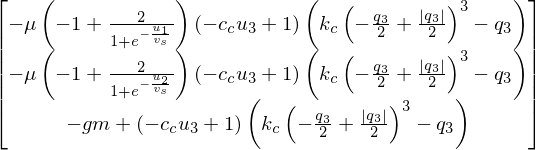

In [11]:
fr

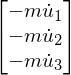

In [12]:
frstar

In [13]:
sys = System(kane)

In [14]:
sys.constants_symbols

In [15]:
sys.constants = {cc: 0.1, #0.85,
                 g: 9.81,
                 kc: 5.0e7,
                 m: 1.0,
                 mu: 0.2, #1.0,
                 vs: 0.01}

In [16]:
sys.times = np.linspace(0.0, 5.0, num=5000)

In [17]:
sys.initial_conditions = {q1: 0.0,
                          q2: 0.0,
                          q3: 5.0,
                          u1: 5.0,
                          u2: 10.0,
                          u3: 0.0}

In [18]:
x = sys.integrate()

<lambdifygenerated-1>:2: RuntimeWarning: overflow encountered in exp
  return ([array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, p[5], 0, 0], [0, 0, 0, 0, p[5], 0], [0, 0, 0, 0, 0, p[5]]]), array([[u[0]], [u[1]], [u[2]], [-p[0]*(-1 + 2/(1 + exp(-u[0]/p[2])))*(-p[3]*u[2] + 1)*(p[4]*(-1/2*q[2] + (1/2)*abs(q[2]))**3 - q[2])], [-p[0]*(-1 + 2/(1 + exp(-u[1]/p[2])))*(-p[3]*u[2] + 1)*(p[4]*(-1/2*q[2] + (1/2)*abs(q[2]))**3 - q[2])], [-p[1]*p[5] + (-p[3]*u[2] + 1)*(p[4]*(-1/2*q[2] + (1/2)*abs(q[2]))**3 - q[2])]])])


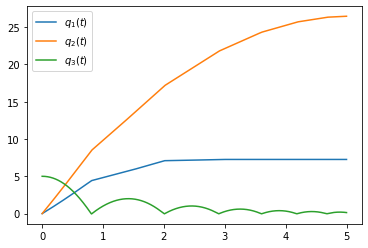

In [19]:
axes = plt.plot(sys.times, x[:, :3])
leg = plt.legend([sm.latex(q, mode='inline') for q in (q1, q2, q3)])

In [20]:
viz_frame = VisualizationFrame('ball', N, P, Sphere(0.2))
scene = Scene(N, O, viz_frame, system=sys)
scene.create_static_html(overwrite=True, silent=True)
matrices = viz_frame.evaluate_transformation_matrix(x, list(sys.constants.values()))

In [21]:
ground_mesh = pjs.Mesh(pjs.PlaneBufferGeometry(40.0, 40.0),
                       pjs.MeshStandardMaterial(color='blue', side='DoubleSide'),
                       name="ground")

ball_mesh = pjs.Mesh(pjs.SphereBufferGeometry(0.2),
                     pjs.MeshStandardMaterial(color='red'),
                     name="ball")

In [22]:
ball_mesh.matrixAutoUpdate = False
ball_mesh.matrix = matrices[0]
ground_mesh.position = [20.0, 20.0, -0.1]

In [23]:
view_width = 800
view_height = 600
camera = pjs.PerspectiveCamera(position=[15, 15, 15], aspect=view_width/view_height)
key_light = pjs.DirectionalLight(position=[0, 100, 100])
ambient_light = pjs.AmbientLight()
scene_pjs = pjs.Scene(children=[ground_mesh, ball_mesh, camera, key_light, ambient_light])
controller = pjs.OrbitControls(controlling=camera)
renderer = pjs.Renderer(camera=camera, scene=scene_pjs, controls=[controller], width=view_width, height=view_height)

In [24]:
renderer

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, position=(15.0, 15.0, 15.0), quaternion=(0.0, 0.0…

In [25]:
track = pjs.VectorKeyframeTrack(name='scene/ball.matrix',
                                times=list(sys.times),
                                values=matrices)
clip = pjs.AnimationClip(tracks=[track], duration=sys.times[-1])
action = pjs.AnimationAction(pjs.AnimationMixer(scene_pjs), clip, scene_pjs)
action

AnimationAction(clip=AnimationClip(duration=5.0, tracks=(VectorKeyframeTrack(name='scene/ball.matrix', times=a…

In [26]:
fr.free_symbols

In [27]:
me.find_dynamicsymbols(fr)

In [28]:
eval_force = sm.lambdify((q3, u1, u2, u3, cc, g, kc, m, mu, vs), fr)

In [29]:
fr_vals = eval_force(*x[:, 2:].T, sys.constants[cc], sys.constants[g], sys.constants[kc], sys.constants[m], sys.constants[mu], sys.constants[vs])

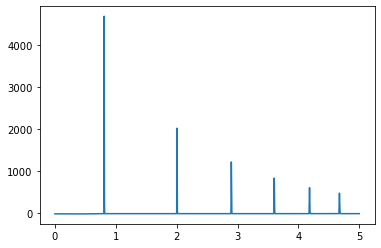

In [30]:
plt.plot(sys.times, fr_vals.squeeze().T[:, 2])